<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/Ensemble_Models/Example_Ensemble_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Loading the car dataset from UCI machine learning databases
import pandas as pd
import numpy as np

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
header = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
          'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
          'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
          'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
          'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg',
          'price']

df = pd.read_csv(url, names=header, na_values='?')

cols_with_missing = df.isnull().sum()
cols_with_missing[cols_with_missing > 0]


normalized-losses    41
num-of-doors          2
bore                  4
stroke                4
horsepower            2
peak-rpm              2
price                 4
dtype: int64

In [2]:
# price is the target variable so remove the 4 records where price is missing
# also drop normalized-losses as there are too many missings
df = df[~df['price'].isnull()]
df = df.drop(labels=['normalized-losses'], axis=1)

In [3]:
features = {
    'categorical': ['make', 'fuel-type', 'aspiration', 'num-of-doors',
                    'body-style', 'drive-wheels', 'engine-location',
                    'engine-type', 'num-of-cylinders', 'fuel-system'],
    'numerical': ['symboling', 'wheel-base', 'length', 'width', 'height',
                  'curb-weight', 'engine-size', 'bore', 'stroke',
                  'compression-ratio', 'horsepower', 'peak-rpm',
                  'city-mpg', 'highway-mpg']}

features['all'] = features['categorical'] + features['numerical']

target = 'price'

df[target] = df[target].astype(np.float64)/1000

df[features['categorical']].sample(n=3,random_state=42)

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
98,nissan,gas,std,two,hardtop,fwd,front,ohc,four,2bbl
16,bmw,gas,std,two,sedan,rwd,front,ohc,six,mpfi
31,honda,gas,std,two,hatchback,fwd,front,ohc,four,1bbl


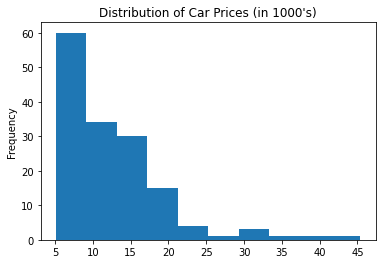

In [4]:
# Split the data into training and test sets
# All other transformations, such as scaling, imputing, and encoding, should be 
# done after splitting the data into training and test sets. In this way, we can
# ensure that no information is leaked from the test set into the training samples.
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)
x_train = df_train[features['all']]
x_test = df_test[features['all']]
y_train = df_train[target]
y_test = df_test[target]

y_train.plot(title="Distribution of Car Prices (in 1000's)",kind='hist')

In [5]:
# The transform function returns numpy ndarrays
# In order to keep the column names:
class ColumnNamesKeeper:
  def __init__(self, transformer):
    self._columns = None
    self.transformer = transformer
  
  def fit(self, x, y=None):
    self._columns = x.columns
    self.transformer.fit(x)

  def transform(self, x, y=None):
    x = self.transformer.transform(x)
    return pd.DataFrame(x, columns=self._columns)

  def fit_transform(self, x, y=None):
    self.fit(x,y)
    return self.transform(x)

In [6]:
# Impute missing values with the most frequent value in each column
# Need to eliminate all missing values before training ensemble models
from sklearn.impute import SimpleImputer

imp = ColumnNamesKeeper(SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
x_train = imp.fit_transform(x_train)
x_test = imp.transform(x_test)

In [ ]:
!pip install category_encoders

In [8]:
# Encoding cateogrical columns
from category_encoders.ordinal import OrdinalEncoder

enc = OrdinalEncoder(cols=features['categorical'], handle_unknown='value')
x_train = enc.fit_transform(x_train)
x_test = enc.transform(x_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Using Random Forest for regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             median_absolute_error, r2_score)

rgr = RandomForestRegressor(n_jobs=-1)
rgr.fit(x_train, y_train)
y_test_pred = rgr.predict(x_test)

print('R2: {:.2f}, MSE: {:.2f}, RMSE: {:.2f}, MAE {:.2f}'.format(
  r2_score(y_test, y_test_pred),
  mean_squared_error(y_test, y_test_pred),
  np.sqrt(mean_squared_error(y_test, y_test_pred)),
  mean_absolute_error(y_test, y_test_pred)))
print("Average car price: {:.2f}".format(df[target].mean()))

R2: 0.93, MSE: 7.07, RMSE: 2.66, MAE 1.71
Average car price: 13.21


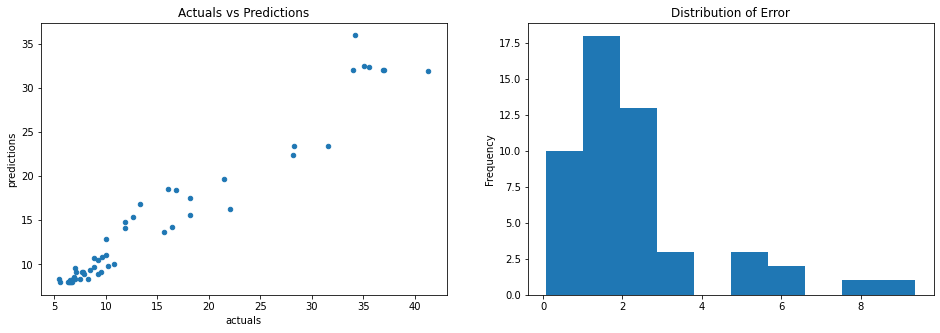

In [12]:
import matplotlib.pyplot as plt

df_pred = pd.DataFrame({
    'actuals': y_test,
    'predictions': y_test_pred
})
df_pred['error'] = np.abs(y_test - y_test_pred)

fig, axs = plt.subplots(1,2,figsize=(16,5),sharey=False)

df_pred.plot(
    title='Actuals vs Predictions',
    kind='scatter',
    x='actuals',
    y='predictions',
    ax=axs[0]
)

df_pred['error'].plot(
    title='Distribution of Error',
    kind='hist',
    ax=axs[1]
)

fig.show()

In [ ]:
# Check of effect of different numbers of trees
mae = []
n_estimators_options = [5, 500, 5000]

for n_estimators in n_estimators_options:
  rgr = RandomForestRegressor(
      n_estimators=n_estimators,
      bootstrap=True,
      max_features=0.75,
      max_samples=0.75,
      n_jobs=-1
  )
  rgr.fit(x_train, y_train)
  y_test_pred = rgr.predict(x_test)
  mae.append(mean_absolute_error(y_test, y_test_pred))

In [ ]:
mae

[1.8404862745098045, 2.108600408496733, 2.0182782342671106]

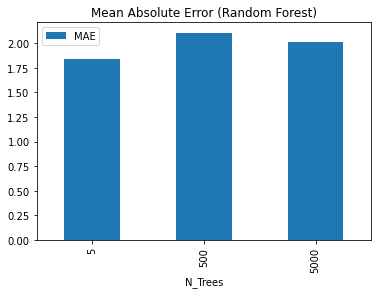

In [ ]:
pd.DataFrame({'MAE': mae, 'N_Trees': n_estimators_options}).plot.bar(x='N_Trees',y='MAE',
                                                                     title='Mean Absolute Error (Random Forest)')

In [ ]:
# Feature importance
df_feature_importance = pd.DataFrame(
    {'Feature': x_train.columns,
     'Importance': rgr.feature_importances_
    }
).sort_values('Importance', ascending=False)

df_feature_importance

,Feature,Importance
15,curb-weight,0.306776
16,engine-size,0.278169
20,horsepower,0.107131
23,highway-mpg,0.080532
22,city-mpg,0.071588
13,width,0.038886
12,length,0.026135
11,wheel-base,0.026005
17,bore,0.009190
21,peak-rpm,0.008830


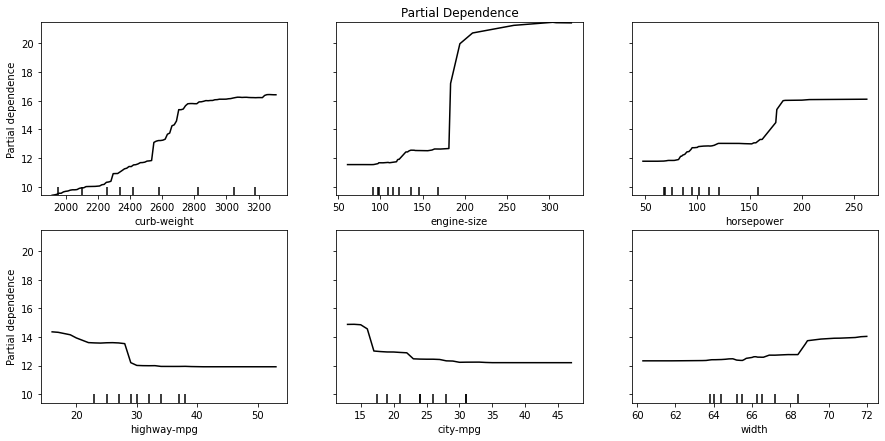

In [ ]:
# Partial Dependence Plot (PDP)
from sklearn.inspection import PartialDependenceDisplay

top_features = df_feature_importance['Feature'].head(6)
fig, ax = plt.subplots(1,1,figsize=(15,7), sharey=False)
PartialDependenceDisplay.from_estimator(
    rgr, x_train, features=top_features, n_cols=3, n_jobs=-1,
    line_kw={'color': 'k'},
    ax=ax
)
ax.set_title('Partial Dependence')
fig.show()

In [ ]:
# Using random forest for classification
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

x, y = make_hastie_10_2(n_samples=6000, random_state=87)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=87)

clf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1)
clf.fit(x_train, y_train)
y_pred_proba = clf.predict_proba(x_test)[:,1]
fpr, tpr, tnr = roc_curve(y_test, y_pred_proba)
auc_values = auc(fpr, tpr)

# Re-train the model with bootstrap set to False
clf1 = RandomForestClassifier(n_estimators=100, bootstrap=False, n_jobs=-1)
clf1.fit(x_train, y_train)
y_pred_proba1 = clf1.predict_proba(x_test)[:,1]
fpr1, tpr1, tnr1 = roc_curve(y_test, y_pred_proba1)
auc_values1 = auc(fpr1, tpr1)

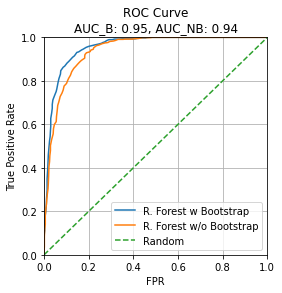

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.set_title('ROC Curve\nAUC_B: {:.2f}, AUC_NB: {:.2f}'.format(auc_values,auc_values1))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
pd.DataFrame(
    {'FPR': fpr, 'TPR': tpr}
).set_index('FPR')['TPR'].plot(label='R. Forest w Bootstrap',grid=True, kind='line', ax=ax)

pd.DataFrame(
    {'FPR': fpr1, 'TPR': tpr1}
).set_index('FPR')['TPR'].plot(label='R. Forest w/o Bootstrap',grid=True,kind='line', ax=ax)

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls='--', label='Random')
ax.legend(loc="lower right")

In [9]:
# Revisit the automobile data with bagging regressor
# Create two parallel pipelines to prepare categorical and numerical feature sets
# separately:
# Numerical Features -> Numerical Imputer -> MinMaxScaler -> Numerical Features
# Categorical Features -> Most Freq. Imputer -> One-Hot Encoder - Categorical Features
from sklearn.impute import SimpleImputer
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

numerical_imputer = ColumnNamesKeeper(
    SimpleImputer(missing_values=np.nan, strategy='median')
)

categorical_imputer = ColumnNamesKeeper(
    SimpleImputer(missing_values=np.nan, strategy='most_frequent')
)

minmax_scaler = ColumnNamesKeeper(MinMaxScaler())

onehot_encoder = OneHotEncoder(cols=features['categorical'],handle_unknown='value')

numerical_pipeline = Pipeline([('numerical_imputer', numerical_imputer),
                               ('minmax_scaler', minmax_scaler)])

categorical_pipeline = Pipeline([('categorical_imputer', categorical_imputer),
                                 ('onehot_encoder', onehot_encoder)])

x_train_knn = pd.concat([
                         numerical_pipeline.fit_transform(df_train[features['numerical']]),
                         categorical_pipeline.fit_transform(df_train[features['categorical']])
], axis=1)

x_test_knn = pd.concat([
                         numerical_pipeline.transform(df_test[features['numerical']]),
                         categorical_pipeline.transform(df_test[features['categorical']])
], axis=1)

In [10]:
# Combining KNN estimators using a bagging meta-estimator
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             median_absolute_error, r2_score)

rgr = BaggingRegressor(
  base_estimator=KNeighborsRegressor(n_neighbors=1), n_estimators=400
)

rgr.fit(x_train_knn, df_train[target])
y_test_pred = rgr.predict(x_test_knn)

print('MAE {:.2f}'.format(mean_absolute_error(y_test, y_test_pred)))

MAE 2.88


In [ ]:
# Using gradient boosting to predict automobile prices
from sklearn.ensemble import GradientBoostingRegressor

rgr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,
                                max_depth=3, loss='squared_error')
rgr.fit(x_train_knn, y_train)
y_test_pred = rgr.predict(x_test_knn)

print('R2: {:.2f}, MSE: {:.2f}, RMSE: {:.2f}, MAE {:.2f}'.format(
  r2_score(y_test, y_test_pred),
  mean_squared_error(y_test, y_test_pred),
  np.sqrt(mean_squared_error(y_test, y_test_pred)),
  mean_absolute_error(y_test, y_test_pred)))

R2: 0.94, MSE: 6.06, RMSE: 2.46, MAE 1.63


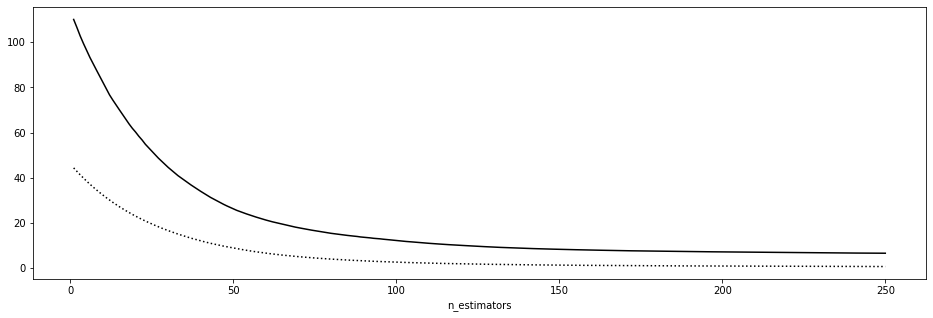

In [ ]:
# Plot the learning deviance which indicates point of overfitting
def calculate_deviance(estimator, x_test, y_test):
  train_errors = estimator.train_score_
  test_errors = [estimator.loss_(y_test, y_pred_staged)
                 for y_pred_staged in estimator.staged_predict(x_test)]
  return pd.DataFrame({
      'n_estimators': range(1, estimator.estimators_.shape[0]+1),
      'train_error': train_errors,
      'test_error': test_errors
  }).set_index('n_estimators')

rgr = GradientBoostingRegressor(n_estimators=250, learning_rate=0.02, loss='squared_error')
rgr.fit(x_train, y_train)

fig, ax = plt.subplots(1,1,figsize=(16,5),sharey=False)
df_deviance = calculate_deviance(rgr, x_test, y_test)
df_deviance['train_error'].plot(kind='line', color='k', linestyle=':', ax=ax)
df_deviance['test_error'].plot(kind='line', color='k', linestyle='-', ax=ax)
fig.show()

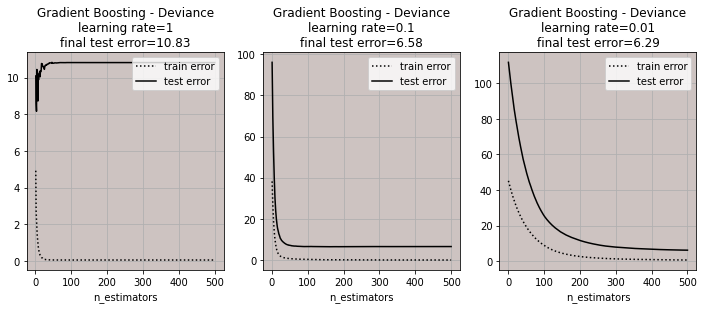

In [ ]:
# Compare learning rate settings
learning_rates = [1,0.1,0.01]

fig, axs = plt.subplots(1,3,figsize=(12,4))
for i, learning_rate in enumerate(learning_rates):
  rgr = GradientBoostingRegressor(n_estimators=500, learning_rate=learning_rate, loss='squared_error')
  rgr.fit(x_train, y_train)
  df_deviance = calculate_deviance(rgr, x_test, y_test)
  df_deviance['train_error'].plot(kind='line', color='k', linestyle=':', label='train error', ax=axs[i])
  df_deviance['test_error'].plot(kind='line', color='k', linestyle='-', label='test error', ax=axs[i])
  axs[i].set_title(f"Gradient Boosting - Deviance\nlearning rate={learning_rate}\nfinal test error={df_deviance['test_error'].iloc[-1]:.2f}")
  axs[i].grid(True)
  axs[i].set_facecolor('#cdc3c1')
  axs[i].legend(loc='upper right')

fig.show()

In [ ]:
import matplotlib.pyplot as plt

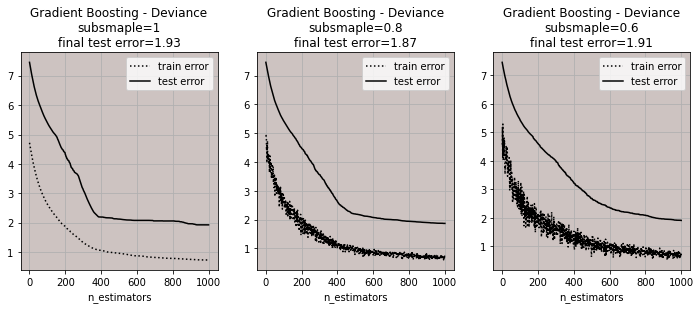

In [ ]:
# Compare sample size settings
subsamples = [1, 0.8, 0.6]
fig, axs = plt.subplots(1,3,figsize=(12,4))
for i, learning_rate in enumerate(subsamples):
  rgr = GradientBoostingRegressor(n_estimators=1000, subsample=subsamples[i], learning_rate=0.01, loss='absolute_error')
  rgr.fit(x_train, y_train)
  df_deviance = calculate_deviance(rgr, x_test, y_test)
  df_deviance['train_error'].plot(kind='line', color='k', linestyle=':', label='train error', ax=axs[i])
  df_deviance['test_error'].plot(kind='line', color='k', linestyle='-', label='test error', ax=axs[i])
  axs[i].set_title(f"Gradient Boosting - Deviance\nsubsmaple={subsamples[i]}\nfinal test error={df_deviance['test_error'].iloc[-1]:.2f}")
  axs[i].grid(True)
  axs[i].set_facecolor('#cdc3c1')
  axs[i].legend(loc='best')

fig.show()

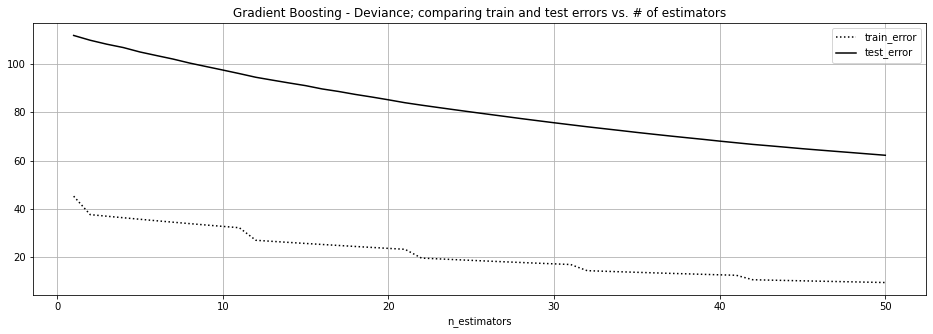

In [ ]:
# Stopping earlier and adapting the learning rate
# an example callback function that changes the learning rate to 0.01 for one 
# iteration at every 10 iterations, and keeps it at 0.1 for the remaining iterations
def lr_changer(n, estimator, params):
  if n % 10:
    estimator.learning_rate = 0.01
  else:
    estimator.learning_rate = 0.1
  return False

rgr = GradientBoostingRegressor(n_estimators=50, learning_rate=0.01, loss='squared_error')
rgr.fit(x_train, y_train, monitor=lr_changer)

fig, ax = plt.subplots(1,1,figsize=(16,5),sharey=False)
df_deviance = calculate_deviance(rgr, x_test, y_test)
df_deviance['train_error'].plot(kind='line', color='k', linestyle=':', label='train_error', ax=ax)
df_deviance['test_error'].plot(kind='line', color='k', linestyle='-', label='test_error', ax=ax)
ax.set_title('Gradient Boosting - Deviance; comparing train and test errors vs. # of estimators')
ax.legend()
ax.grid(True)
fig.show()

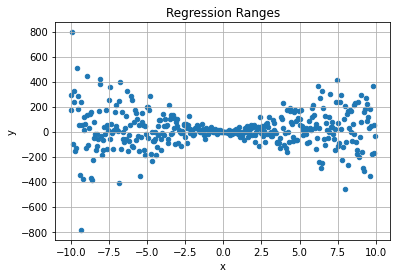

In [ ]:
# Test of regression ranges
x_sample = np.arange(-10,10,0.05)
y_sample = np.random.normal(loc=0, scale=25, size=x_sample.shape[0])
y_sample *= x_sample

pd_random_samples = pd.DataFrame(
    {
     'x': x_sample,
     'y': y_sample
    }
).plot.scatter(x='x', y='y', grid=True, title='Regression Ranges')

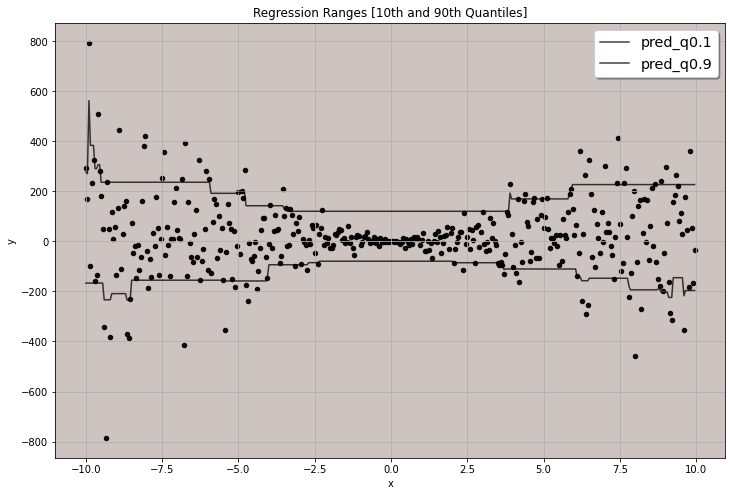

In [ ]:
pd_random_samples = pd.DataFrame(
    {
     'x': x_sample,
     'y': y_sample
    }
)

fig, ax = plt.subplots(1,1,figsize=(12,8),sharey=False)
pd_random_samples.plot(title='Regression Ranges [10th and 90th Quantiles]', 
                      kind='scatter', x='x', y='y', color='k', alpha=0.95, ax=ax)

for quantile in [0.1, 0.9]:
  rgr = GradientBoostingRegressor(n_estimators=10, loss='quantile', alpha=quantile)
  rgr.fit(pd_random_samples[['x']], pd_random_samples['y'])
  pd_random_samples[f'pred_q{quantile}'] = rgr.predict(pd_random_samples[['x']])
  pd_random_samples.plot(kind='line',x='x',y=f'pred_q{quantile}',linestyle='-',
                         alpha=0.75, color='k', ax=ax)

ax.set_facecolor('#cdc3c1')
ax.grid()
ax.legend(ncol=1, fontsize='x-large', shadow=True)
fig.show()

In [ ]:
# apply regression ranges to the automobile data

rgr_min = GradientBoostingRegressor(n_estimators=50, loss='quantile', alpha=0.25)
rgr_max = GradientBoostingRegressor(n_estimators=50, loss='quantile', alpha=0.75)

rgr_min.fit(x_train, y_train, monitor=lr_changer)
rgr_max.fit(x_train, y_train, monitor=lr_changer)

y_test_pred_min = rgr_min.predict(x_test)
y_test_pred_max = rgr_max.predict(x_test)

df_pred_range = pd.DataFrame(
    {
      'Actuals': y_test,
      'Pred_min': y_test_pred_min,
      'Pred_max': y_test_pred_max
    }
)

df_pred_range['Actuals in Range?'] = df_pred_range.apply(
    lambda row: 1 if row['Actuals'] >= row['Pred_min'] and row['Actuals'] <= row['Pred_max'] else 0, axis=1
)

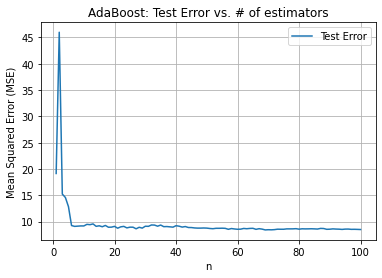

In [13]:
# Example of AdaBoost ensemble, which alters the weights of the training samples based on 
# mistakes made in each iteration
from sklearn.ensemble import AdaBoostRegressor

rgr = AdaBoostRegressor(n_estimators=100)
rgr.fit(x_train, y_train)
y_test_pred = rgr.predict(x_test)

fig, ax = plt.subplots(1,1)
pd.DataFrame(
    [
     (n, mean_squared_error(y_test, y_pred_staged))
     for n, y_pred_staged in enumerate(rgr.staged_predict(x_test), 1)
    ],
    columns=['n', 'Test Error']
).set_index('n').plot(ylabel='Mean Squared Error (MSE)', title='AdaBoost: Test Error vs. # of estimators', ax=ax)

ax.grid()
fig.show()

In [14]:
# Random tree embedding
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

rgr = make_pipeline(RandomTreesEmbedding(), Ridge())
rgr.fit(x_train, y_train)
y_test_pred = rgr.predict(x_test)
print(f'MSE: {mean_squared_error(y_test, y_test_pred)}')

MSE: 7.6790868966089425
